# Image Segmentation con arquitecura UNet y fastai2

Breve introducción a la segmentación de imágenes, en particular utilizando la arquitectura Unet, una técnica de vanguardia que ha ganado muchos concursos de Kaggle y es ampliamente utilizada en la industria. Los modelos de segmentación de imágenes nos permiten clasificar con precisión cada parte de una imagen, hasta el nivel de píxel.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

Librerias necesarias:

In [2]:
from fastai.vision.all import *

import numpy as np
import pandas as pd
import torch
from pathlib import Path

In [3]:
torch.cuda.is_available()

True

## Camvid: Motion-based Segmentation and Recognition Dataset <br>

La biblioteca fastai, viene con la clase URLs que le permiten descargar algunos conjuntos de datos seleccionados. Los conjuntos de datos con SAMPLE o TINY en su nombre son subconjuntos de los conjuntos de datos originales. Para obtener detalles sobre los conjuntos de datos, puede ver la página web de conjuntos de datos fast.ai. <br>
En este caso, los datos que vamos a utilizar son CAMVID_TINY para segmentación semántica por píxel de más de 700 imágenes, cada una inspeccionada y confirmada por una segunda persona para garantizar su precisión y podemos obtenerlos llamando como en la siguiente celda:

In [4]:
path = untar_data(URLs.CAMVID_TINY)

In [5]:
!ls {path}

codes.txt  images  labels  models


In [6]:
path_lbl = path/'labels'
path_img = path/'images'

Extraemos los nombres de las imagenes:

In [7]:
fnames = get_image_files(path_img)

In [8]:
fnames[0]

Path('/home/pclemente/.fastai/data/camvid_tiny/images/Seq05VD_f01320.png')

In [9]:
lbl_names = get_image_files(path_lbl)
lbl_names[0]

Path('/home/pclemente/.fastai/data/camvid_tiny/labels/0016E5_07290_P.png')

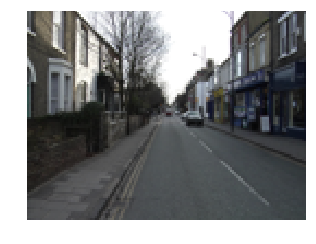

In [10]:
img_f = fnames[0]
img = PILImage.create(img_f)
img.show(figsize=(5,5))

Función para etiquetar las imagenes:

In [11]:
def label_func(x): return path_lbl/f'{x.stem}_P{x.suffix}'

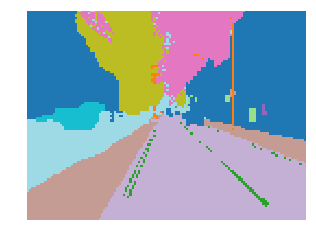

In [12]:
mask = PILMask.create(label_func(img_f))
mask.show(figsize=(5,5), alpha=1)

In [13]:
src_size = np.array(mask.shape[1:])
src_size,tensor(mask)

(array([128]), tensor([[ 4,  4,  4,  ...,  4,  4,  4],
         [ 4,  4,  4,  ...,  4,  4,  4],
         [ 4,  4,  4,  ...,  4,  4,  4],
         ...,
         [19, 19, 19,  ..., 17, 17, 17],
         [19, 19, 19,  ..., 17, 17, 17],
         [19, 19, 19,  ..., 17, 17, 17]], dtype=torch.uint8))

Guardar los códigos para cada clase de segmentación del archivo codes.txt:

In [14]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

In [15]:
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [16]:
size = src_size//2
bs=8

## En este caso existen 2 formas de __cargar los datos__ con la libreria fastai:

## 1. High level API

In [17]:
#dls = SegmentationDataLoaders.from_label_func(path, fnames, label_func, codes=codes, bs=32)

## 2. Mid level API

In [18]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   get_y=label_func,
                   item_tfms=Resize(224),
                   batch_tfms=[*aug_transforms(size=(120,160)), Normalize.from_stats(*imagenet_stats)])#I chose the size as (120, 160) because why not

In [19]:
dls = camvid.dataloaders(path/"images", bs=8, path=path)

### Ahora mostraremos un batch de imágenes:

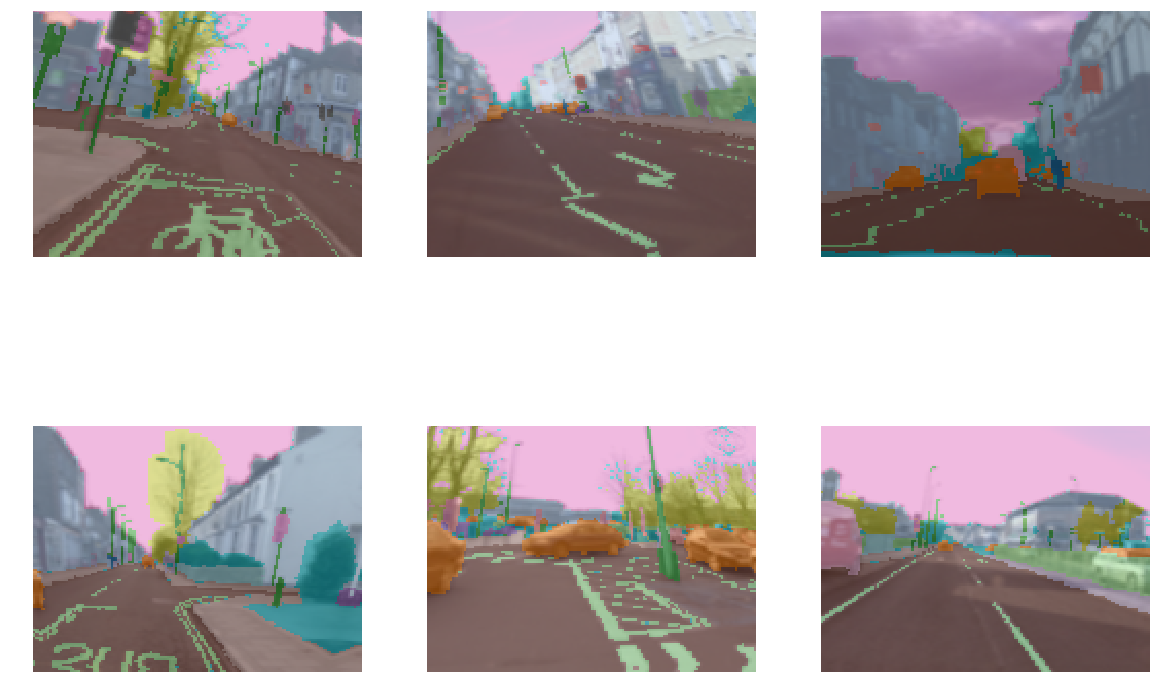

In [20]:
dls.show_batch(max_n=6, figsize=(20,14))

## Model

In [21]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [22]:
metrics=acc_camvid
wd=1e-2
dls.vocab = codes

In [23]:
learn = unet_learner(dls, arch=resnet34, metrics=metrics)

In [24]:
learn.model

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

## Entrenamiento

SuggestedLRs(lr_min=0.002290867641568184, lr_steep=0.0004786300996784121)

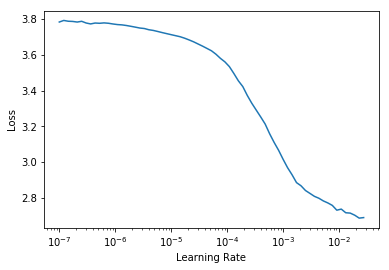

In [25]:
learn.lr_find()

In [26]:
lr= 3e-3

In [27]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9, wd=wd)

epoch,train_loss,valid_loss,acc_camvid,time
0,2.861234,2.118417,0.545981,00:04
1,2.252212,1.561125,0.608796,00:03
2,1.875079,1.089240,0.713471,00:03
3,1.661623,1.415284,0.617758,00:03
4,1.563059,1.092050,0.674434,00:03
5,1.418043,1.202812,0.709252,00:03
6,1.404272,1.372642,0.585470,00:03
7,1.358577,1.241237,0.625181,00:03
8,1.338036,1.331878,0.620214,00:03
9,1.304023,1.110138,0.661551,00:03


SuggestedLRs(lr_min=0.0002511886414140463, lr_steep=1.737800812406931e-05)

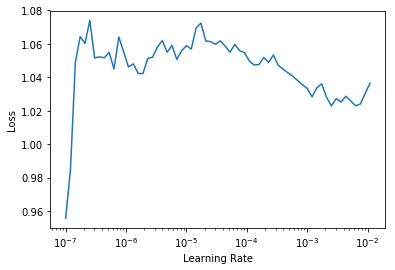

In [28]:
learn.lr_find()

In [29]:
lr= 3e-3

In [30]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9, wd=wd)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.036875,1.015262,0.690636,00:03
1,1.013531,0.976273,0.701382,00:03
2,0.972471,0.898183,0.739434,00:03
3,0.935637,0.811747,0.795247,00:03
4,0.904794,0.837361,0.786108,00:03
5,0.875310,0.758031,0.802571,00:03
6,0.848657,0.777837,0.806181,00:03
7,0.824827,0.810262,0.784336,00:03
8,0.808214,0.972522,0.744423,00:03
9,0.801118,0.716391,0.806856,00:03


In [31]:
learn.save('stage-1.1')

Path('/home/pclemente/.fastai/data/camvid_tiny/models/stage-1.1.pth')

In [32]:
learn.load('stage-1.1');

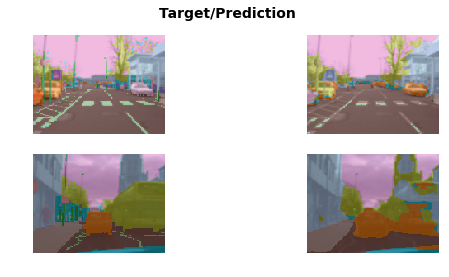

In [33]:
learn.show_results(max_n=6, figsize=(9, 4))

In [34]:
learn.unfreeze()

In [35]:
lrs = slice(lr/400,lr/4)

In [36]:
learn.fit_one_cycle(12, lrs, pct_start=0.8, wd=wd)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.687684,0.691554,0.818820,00:04
1,0.671475,0.661240,0.826041,00:03
2,0.666084,0.637537,0.831232,00:03
3,0.656766,0.642205,0.829952,00:03
4,0.643230,0.623061,0.833628,00:03
5,0.627652,0.596986,0.838103,00:03
6,0.616768,0.603482,0.835465,00:03
7,0.600567,0.608259,0.834854,00:03
8,0.596278,0.606739,0.831468,00:03
9,0.594496,0.627378,0.834088,00:03


In [37]:
learn.save('stage-2.1');

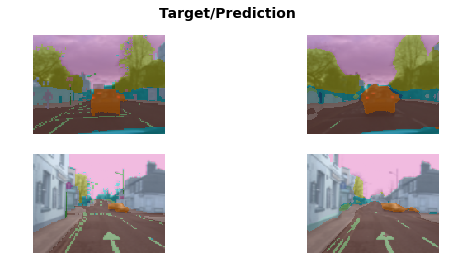

In [38]:
learn.show_results(max_n=6, figsize=(9, 4))

## Más entrenamiento

Es posible que deba reiniciar su kernel y volver a esta etapa si se queda sin memoria, y es posible que también deba disminuir el bs.

In [39]:
del learn
import gc
gc.collect()

24183

In [43]:
free= !free

In [59]:
free

['              total        used        free      shared  buff/cache   available',
 'Mem:       16377964     3567312     7541584       15380     5269068    12457556',
 'Swap:       2097148           0     2097148']

In [60]:
free_mem= free[1][36:42]

In [61]:
size = src_size
bs=3
#depending on your GPU RAM you may need to use
# bs=1
print(f"using bs={bs}, have {free_mem}MB of GPU RAM free")

using bs=3, have 754158MB of GPU RAM free


In [62]:
dls = camvid.dataloaders(path/"images", bs=3, path=path,
                          batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)])

In [63]:
dls.vocab = codes

In [64]:
learn = unet_learner(dls, resnet34, metrics=metrics)

In [65]:
learn.load('stage-2.1');

SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=4.786300905834651e-06)

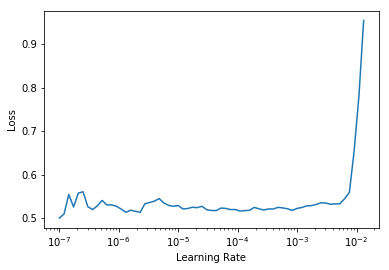

In [66]:
learn.lr_find()

In [67]:
lr=1e-3

In [68]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.540999,0.573347,0.844153,00:05
1,0.523882,0.575082,0.839654,00:04
2,0.525154,0.585786,0.840646,00:04
3,0.526166,0.594932,0.841319,00:04
4,0.532115,0.625957,0.832342,00:04
5,0.544962,0.626528,0.828450,00:04
6,0.556978,0.666614,0.825079,00:04
7,0.556491,0.631822,0.838498,00:04
8,0.544178,0.645187,0.832770,00:04
9,0.519054,0.583871,0.843971,00:04


In [69]:
learn.save('stage-1-big')

Path('/home/pclemente/.fastai/data/camvid_tiny/models/stage-1-big.pth')

In [70]:
learn.load('stage-1-big');

In [71]:
learn.unfreeze()

In [72]:
lrs = slice(1e-6,lr/10)

In [73]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.478108,0.565263,0.844319,00:05
1,0.472439,0.558727,0.847053,00:05
2,0.469302,0.568330,0.842780,00:05
3,0.458961,0.556346,0.844986,00:05
4,0.456099,0.553806,0.845987,00:05
5,0.454389,0.556741,0.847147,00:05
6,0.444734,0.549873,0.845700,00:05
7,0.437082,0.547681,0.846958,00:05
8,0.437747,0.545341,0.847516,00:05
9,0.430610,0.547817,0.846569,00:05


In [74]:
learn.save('stage-2-big')

Path('/home/pclemente/.fastai/data/camvid_tiny/models/stage-2-big.pth')

In [75]:
learn.load('stage-2-big');

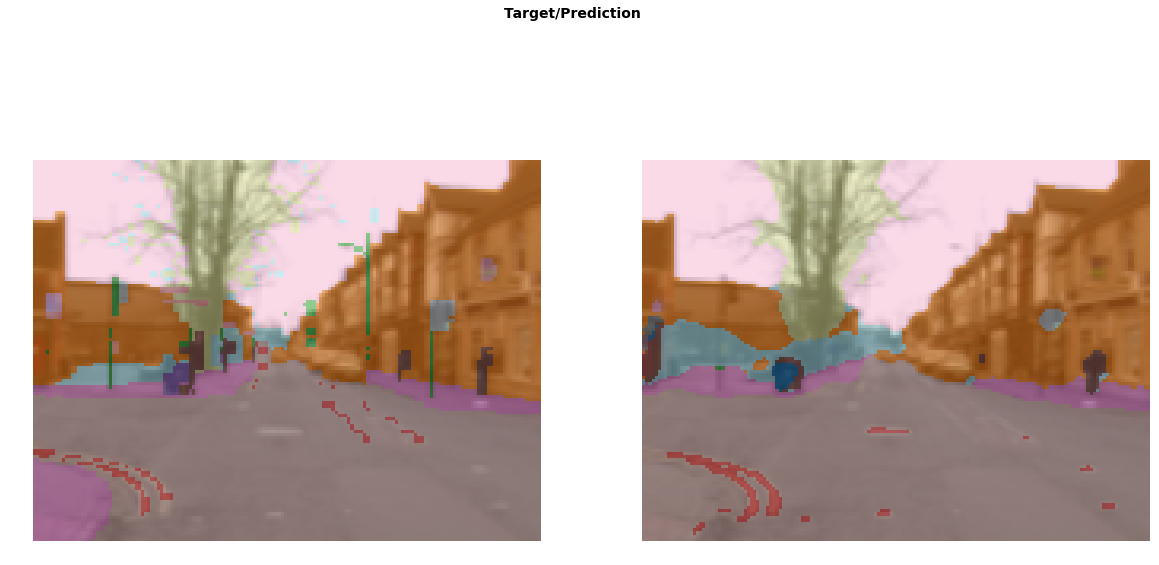

In [76]:
learn.show_results(max_n=1, figsize=(20,10), vmin=1, vmax=30)

# Referencias:

- https://course.fast.ai/datasets
- https://tezike.github.io/blog/posts/2020/04/01/Understanding-fastai-vision.html#The-DATABLOCK
- https://docs.fast.ai/vision.data.html#ImageBlock
- https://course18.fast.ai/lessons/lesson14.html
- https://forums.fast.ai/t/fine-tune-vs-fit-one-cycle-unfreeze-fit-one-cycle/66704/8